In [1]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [2]:
data = pd.read_csv("dataset_without_hog.csv")

# CHECK CLASS IMBALANCE


In [3]:
class_counts = data['label'].value_counts()
print(class_counts)

label
0    2700
1    2700
2    2700
3    2700
4    2700
Name: count, dtype: int64


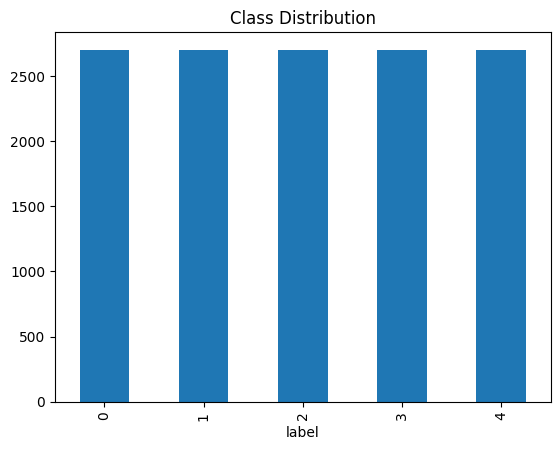

In [4]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [5]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: count, dtype: float64


# SPLIT DATA

In [6]:
x = data.drop("label", axis=1)
y = data['label']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [8]:
X_train[0]

array([17, 17, 17, ..., 25, 28, 23])

# SCALE DATA

In [9]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAIN

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình DecisionTree với các tham số cụ thể
DecisionTree_model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20, min_samples_split=5, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

DecisionTree_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = DecisionTree_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.4111111111111111


# EVALUATE

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tabulate import tabulate

# Assume y_test and y_pred are already defined

# Calculate precision, recall, and f1-score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

# Calculate overall precision, recall, and f1-score
overall_precision = precision.mean()
overall_recall = recall.mean()
overall_f1 = f1.mean()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create the table
table = []
for i in range(len(class_names)):
    table.append([class_names[i], f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])
table.append(["Overall", f"{overall_precision:.4f}", f"{overall_recall:.4f}", f"{overall_f1:.4f}"])

# Print the table
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score"], tablefmt="grid"))

# Print accuracy
print(f"\nAccuracy: {accuracy:.4f}")

+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-Score |
+=========+=============+==========+============+
| Angry   |      0.3269 |   0.345  |     0.3357 |
+---------+-------------+----------+------------+
| Fear    |      0.3539 |   0.3702 |     0.3619 |
+---------+-------------+----------+------------+
| Happy   |      0.5616 |   0.5581 |     0.5598 |
+---------+-------------+----------+------------+
| Neutral |      0.4968 |   0.4707 |     0.4834 |
+---------+-------------+----------+------------+
| Sad     |      0.3263 |   0.3119 |     0.319  |
+---------+-------------+----------+------------+
| Overall |      0.4131 |   0.4112 |     0.4119 |
+---------+-------------+----------+------------+

Accuracy: 0.4111


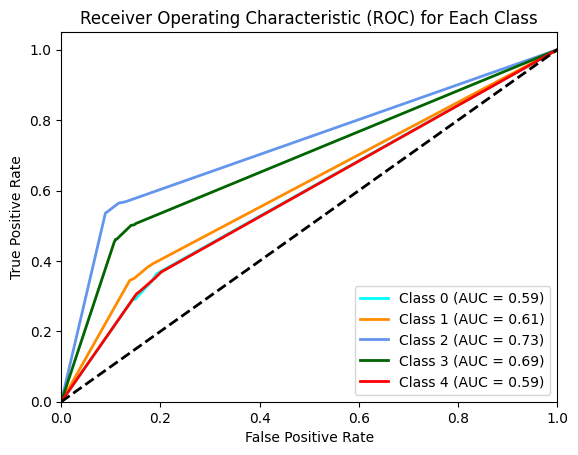

In [18]:
# Import necessary libraries
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Predict probabilities
y_score = DecisionTree_model.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Each Class')
plt.legend(loc="lower right")
plt.show()


# SAVE MODEL

In [13]:
import pickle

with open('dt_model_without_hog.pkl', 'wb') as f:
    pickle.dump(DecisionTree_model, f)

In [14]:
from joblib import dump
dump(DecisionTree_model, 'dt_model_without_hog.h5')

['dt_model_without_hog.h5']

# Tune

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Thiết lập các giá trị thử nghiệm cho các tham số
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.41259259259259257
